In [ ]:
# Instalações necessárias
!pip install -q tensorflow kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.9 MB/s eta 0:00:00


In [ ]:
# Silencia mensagens do TF
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [ ]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import kagglehub
import os

In [ ]:
# Baixa o dataset do kaggle
path = kagglehub.dataset_download("tarunparuchur/pneumonia-classification-from-chest-x-rays")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pneumonia-classification-from-chest-x-rays' dataset.
Path to dataset files: /kaggle/input/pneumonia-classification-from-chest-x-rays


In [ ]:
# Caminhos principais
train_dir = os.path.join(path, "chest_xray/train")
val_dir   = os.path.join(path, "chest_xray/val")
test_dir  = os.path.join(path, "chest_xray/test")

In [ ]:
# Carregar as imagens com ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalização + aumento de dados (data augmentation)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   zoom_range=0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Geradores
batch_size = 32
img_size = (150, 150)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Converte os generators do Kaggle em arrays
def generator_to_numpy(generator):
    x, y = [], []
    for i in range(len(generator)):
        imgs, labels = generator[i]
        x.append(imgs)
        y.append(labels)
    return np.concatenate(x), np.concatenate(y)

x_train_kaggle, y_train_kaggle = generator_to_numpy(train_generator)
x_val_kaggle, y_val_kaggle     = generator_to_numpy(val_generator)
x_test_kaggle, y_test_kaggle   = generator_to_numpy(test_generator)

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.7/146.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.8/241.8 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.4/224.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.6/355.6 kB 25.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.9.0
    Uninstalling fsspec-2025.9.0:
      Successfully uninstalled fsspec-2025.9.0


In [ ]:
# Baixar o dataset do hugging face
from datasets import load_dataset

ds = load_dataset("hf-vision/chest-xray-pneumonia")

def preprocess(example):
    image = example["image"].convert("RGB").resize(img_size)
    image = np.array(image) / 255.0
    return image, example["label"]

x_train_hf, y_train_hf = zip(*[preprocess(ex) for ex in ds["train"]])
x_val_hf, y_val_hf     = zip(*[preprocess(ex) for ex in ds["validation"]])
x_test_hf, y_test_hf   = zip(*[preprocess(ex) for ex in ds["test"]])

x_train_hf, y_train_hf = np.array(x_train_hf), np.array(y_train_hf)
x_val_hf, y_val_hf     = np.array(x_val_hf), np.array(y_val_hf)
x_test_hf, y_test_hf   = np.array(x_test_hf), np.array(y_test_hf)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00007.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

data/train-00001-of-00007.parquet:   0%|          | 0.00/385M [00:00<?, ?B/s]

data/train-00002-of-00007.parquet:   0%|          | 0.00/68.9M [00:00<?, ?B/s]

data/train-00003-of-00007.parquet:   0%|          | 0.00/74.1M [00:00<?, ?B/s]

data/train-00004-of-00007.parquet:   0%|          | 0.00/59.9M [00:00<?, ?B/s]

data/train-00005-of-00007.parquet:   0%|          | 0.00/57.6M [00:00<?, ?B/s]

data/train-00006-of-00007.parquet:   0%|          | 0.00/57.8M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/78.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5216 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/16 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/624 [00:00<?, ? examples/s]

In [ ]:
# Função para limitar por classe
def limitar_por_classe(x, y, limite_por_classe=1000):
    """Recebe arrays X, y e retorna no máximo 'limite_por_classe' exemplos por classe"""
    x_final, y_final = [], []

    for classe in np.unique(y):
        idxs = np.where(y == classe)[0]
        np.random.shuffle(idxs)
        idxs = idxs[:limite_por_classe]

        x_final.append(x[idxs])
        y_final.append(y[idxs])

    return np.concatenate(x_final), np.concatenate(y_final)

# ====== Aplicar limites ======

# Treino
x_train_kaggle, y_train_kaggle = limitar_por_classe(x_train_kaggle, y_train_kaggle, limite_por_classe=1000)
x_train_hf,     y_train_hf     = limitar_por_classe(x_train_hf,     y_train_hf,     limite_por_classe=1000)

# Validação
x_val_kaggle, y_val_kaggle = limitar_por_classe(x_val_kaggle, y_val_kaggle, limite_por_classe=500)
x_val_hf,     y_val_hf     = limitar_por_classe(x_val_hf,     y_val_hf,     limite_por_classe=500)

# Teste
x_test_kaggle, y_test_kaggle = limitar_por_classe(x_test_kaggle, y_test_kaggle, limite_por_classe=500)
x_test_hf,     y_test_hf     = limitar_por_classe(x_test_hf,     y_test_hf,     limite_por_classe=500)


In [ ]:
#Concatenar os dois datasets


x_train = np.concatenate([x_train_kaggle, x_train_hf])
y_train = np.concatenate([y_train_kaggle, y_train_hf])

x_val   = np.concatenate([x_val_kaggle, x_val_hf])
y_val   = np.concatenate([y_val_kaggle, y_val_hf])

x_test  = np.concatenate([x_test_kaggle, x_test_hf])
y_test  = np.concatenate([y_test_kaggle, y_test_hf])

In [ ]:
# Classes do problema
nomes_classes = list(train_generator.class_indices.keys())
print("Classes:", nomes_classes)

Classes: ['NORMAL', 'PNEUMONIA']


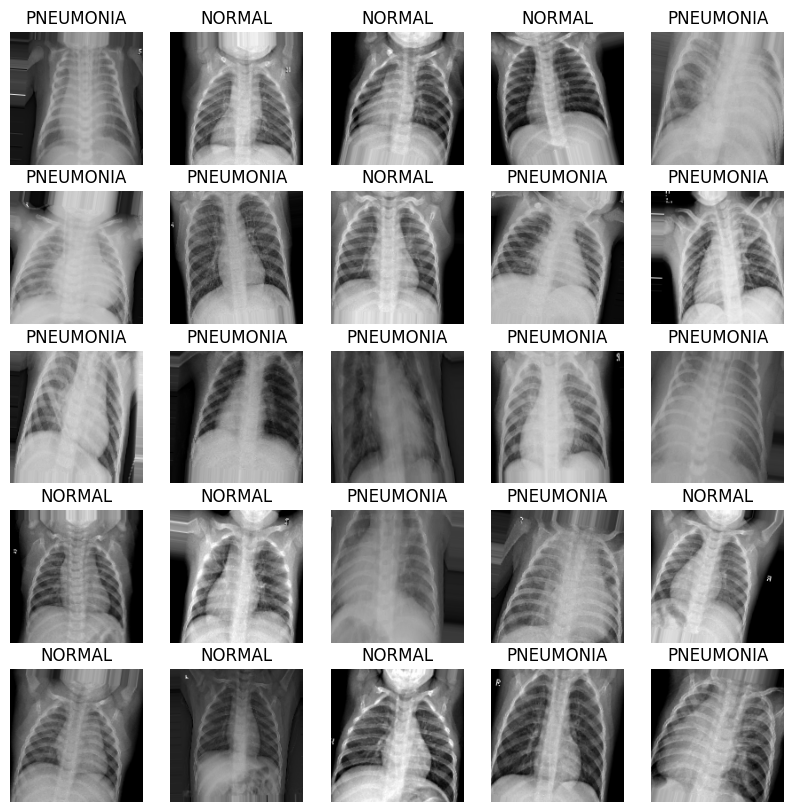

In [ ]:
# Visualização de algumas imagens
def visualiza_imagens(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i])
        plt.title(nomes_classes[int(labels[i])])
        plt.axis("off")
    plt.show()

visualiza_imagens(train_generator)

In [ ]:
# Importa base já treinada
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(150,150,3),
    include_top=False,      # não usa as camadas finais originais
    weights='imagenet'      # carrega pesos treinados no ImageNet
)

# Congela a base (não treina de novo os pesos dela)
base_model.trainable = False

# Cria o modelo final
modelo_lia = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),   # "achata" mantendo info espacial
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


/tmp/ipython-input-1003390191.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compilação
modelo_lia.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(2000).batch(batch_size)
val_ds   = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
test_ds  = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Treinamento com mais épocas
history = modelo_lia.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    callbacks=[early_stop]
)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 115s 877ms/step - accuracy: 0.8126 - loss: 0.4415 - val_accuracy: 0.8438 - val_loss: 0.3100
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 104s 832ms/step - accuracy: 0.9162 - loss: 0.2153 - val_accuracy: 0.7812 - val_loss: 0.4149
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 820ms/step - accuracy: 0.9358 - loss: 0.1685 - val_accuracy: 0.7812 - val_loss: 0.3737
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 821ms/step - accuracy: 0.9414 - loss: 0.1581 - val_accuracy: 0.8438 - val_loss: 0.3272


In [ ]:
# Avaliação
erro_teste, acc_teste = modelo_lia.evaluate(test_ds, verbose=2)
print("\nAcurácia com dados de Teste (Kaggle + HF):", acc_teste)

39/39 - 35s - 889ms/step - accuracy: 0.8806 - loss: 0.3086

Acurácia com dados de Teste (Kaggle + HF): 0.8806089758872986


In [ ]:
# Previsões no conjunto de teste combinado (Kaggle + HF)
y_pred = modelo_lia.predict(test_ds)
y_pred_classes = (y_pred > 0.8).astype("int32").flatten()
y_true = y_test   # já vem concatenado


39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 905ms/step


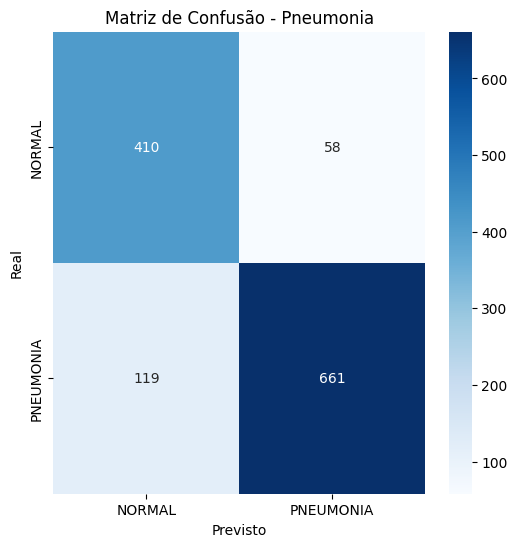

In [ ]:
# Matriz de confusão
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nomes_classes,
            yticklabels=nomes_classes)
plt.title('Matriz de Confusão - Pneumonia')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

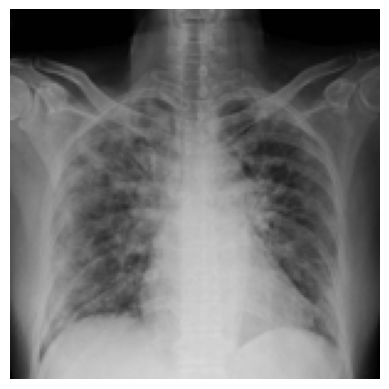

In [ ]:
# Testando com uma imagem nova
nova_imagem = Image.open("/content/teste2.jpg")  # substitua pelo caminho da imagem
nova_imagem = nova_imagem.resize(img_size)

plt.imshow(nova_imagem)
plt.axis("off")
plt.show()

In [ ]:
# Prepara imagem para predição
nova_imagem_array = np.array(nova_imagem) / 255.0
nova_imagem_array = np.expand_dims(nova_imagem_array, axis=0)

# Faz a predição
previsao = modelo_lia.predict(nova_imagem_array)
probabilidade = previsao[0][0]

# Define a classe e a confiança
if probabilidade > 0.5:
    classe_prevista = nomes_classes[1]  # pneumonia
    confianca = probabilidade * 100
else:
    classe_prevista = nomes_classes[0]  # normal
    confianca = (1 - probabilidade) * 100

print(f"A nova imagem foi classificada como: {classe_prevista} com {confianca:.2f}% de confiança")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
A nova imagem foi classificada como: PNEUMONIA com 97.99% de confiança
